In [34]:
#TODO: divide image into tiles, 
#       design yolo works on tiles
#        add a network segment to combine the result
#         train the model on MNIST

In [35]:

#TODO: relearn the procedure, refractor the code
from __future__ import division
import numpy as np
import torch as t
import torchvision as tv
import torchvision.transforms as transform
import torch.nn as nn
import torch.nn.functional as F

import yolo_base
import test_utils

import imp
imp.reload(test_utils)
imp.reload(yolo_base)

use_cuda = t.cuda.is_available()
device = t.device("cuda:0" if use_cuda else "cpu")


tile_size = 416#1472#416#1472#768#416
overlap = 64
step = tile_size - overlap
tile_nh = 2
tile_nw = 2
tile_n = tile_nh * tile_nw
img_size_h = tile_size * tile_nh - (tile_nh - 1) * overlap
img_size_w = tile_size * tile_nw - (tile_nw - 1) * overlap


def cut_tiles(img, tile_size, step):
    #img shape: batch, channel, 
    return img.data.unfold(2, tile_size, step).unfold(3, tile_size, step)

def get_tile(tiles, hi, wi):
    #TODO: return batch of tiles, shape (bath, channel, tile_size, tile_size)
    return tiles[:, :, hi, wi, :, :]

def get_tile_list(img, tile_size, step):
    tiles = cut_tiles(img, tile_size, step)
    b, c, tile_nw, tile_nh, h, w = tiles.shape
    result = []
    for i in range(tile_nw):
        for j in range(tile_nh):
            result.append(get_tile(tiles, i, j))
    return result

def show_tile(tiles, batch_idx, hi, wi):
    #TODO: visualize a specific tile, given batch index, pos_h, pos_w
    tile = tiles[:, :, hi, wi, :, :]
    plt.imshow(np.array(tile.data).transpose(0, 2, 3, 1)[batch_idx])
    plt.figure()

def forward(net_base, net_comblist, net_pred, tile_list, device):
    fx = t.Tensor().type(t.FloatTensor).to(device)
    for idx, tile in enumerate(tile_list):
        tile = tile.type(t.FloatTensor).to(device)
        fxi = net_base(tile)
        fxi = net_comblist[idx](fxi)
        fx = t.cat((fx, fxi), 1)#Stack by CHANNEL
    fx = net_pred(fx)
    return fx

def eval_accuracy(net_base, net_comblist, net_pred, testloader, device):
    correct = 0
    total = 0
    with t.no_grad():
        for i, (img_list, label_list) in enumerate(testloader):
            label_list = label_list.to(device)
            tile_list = get_tile_list(img_list, tile_size, step)
            fx = forward(net_base, net_comblist, net_pred, tile_list, device)
            _, predicted = t.max(fx.data, 1)
            total += label_list.size(0)
            correct += (predicted == label_list).sum().item()
    return correct, total


class Combiner(t.nn.Module):
    def __init__(self):
        super(Combiner, self).__init__()
        self._n_in_filters = 1024
        self._n_out_filters = 32#128 for 2x2, 32 for 4x4
        self._conv1 = nn.Conv2d(self._n_in_filters, self._n_out_filters, 1, padding=0)
        self._bn = nn.BatchNorm2d(self._n_out_filters)
        
    def forward(self, tile):
        x = self._bn(self._conv1(tile))
        return x


class Predictor(t.nn.Module):
    #TODO: train a dummy model for CIFAR, will improve upon this one
    def __init__(self):
        super(Predictor, self).__init__()
        N_in, N_res, N_1x1, N_3x3, N_out = 512, 512, 128, 512, 10
        
        self.aapool = nn.AdaptiveAvgPool2d(1)
        
        self.conv1_res = nn.Conv2d(N_in, N_res, 1)
        self.conv1_1x1 = nn.Conv2d(N_in, N_1x1, 1)
        self.conv1 = nn.Conv2d(N_1x1, N_3x3, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(N_3x3)
        
        self.conv2_res = nn.Conv2d(N_in, N_res, 1)
        self.conv2_1x1 = nn.Conv2d(N_in, N_1x1, 1)
        self.conv2 = nn.Conv2d(N_1x1, N_3x3, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(N_3x3)
        
        self.conv3_res = nn.Conv2d(N_in, N_res, 1)
        self.conv3_1x1 = nn.Conv2d(N_in, N_1x1, 1)
        self.conv3 = nn.Conv2d(N_1x1, N_3x3, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(N_3x3)
        
        self.conv4_res = nn.Conv2d(N_in, N_res, 1)
        self.conv4_1x1 = nn.Conv2d(N_in, N_1x1, 1)
        self.conv4 = nn.Conv2d(N_1x1, N_3x3, 3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(N_3x3)
        
        self.conv5_res = nn.Conv2d(N_in, N_res, 1)
        self.conv5_1x1 = nn.Conv2d(N_in, N_1x1, 1)
        self.conv5 = nn.Conv2d(N_1x1, N_3x3, 3, padding=1)
        self.conv5_bn = nn.BatchNorm2d(N_3x3)
        
        self.conv6_res = nn.Conv2d(N_in, N_res, 1)
        self.conv6_1x1 = nn.Conv2d(N_in, N_1x1, 1)
        self.conv6 = nn.Conv2d(N_1x1, N_3x3, 3, padding=1)
        self.conv6_bn = nn.BatchNorm2d(N_3x3)
        
        self.conv_last = nn.Conv2d(N_in, N_in, 3, padding=1)
        self.conv_last_bn = nn.BatchNorm2d(N_in)
        
        self.fc1 = nn.Linear(N_in, N_out)
        
    def forward(self, x):
        c = self.conv1_bn(F.relu(self.conv1(self.conv1_1x1(x))))
        #r = self.conv1_res(x)
        x = c + x
        #x = t.cat((c, r), 1)
        
        c = self.conv2_bn(F.relu(self.conv2(self.conv2_1x1(x))))
        x = c + x
        
        c = self.conv3_bn(F.relu(self.conv3(self.conv3_1x1(x))))
        x = c + x
        
        c = self.conv4_bn(F.relu(self.conv4(self.conv4_1x1(x))))
        x = c + x
        
        c = self.conv5_bn(F.relu(self.conv5(self.conv5_1x1(x))))
        x = c + x
        
        c = self.conv6_bn(F.relu(self.conv6(self.conv6_1x1(x))))
        x = c + x
        
        #x = F.relu(self.conv3_bn(self.conv3(self.conv3_1x1(x))))
        #x = F.relu(self.conv4_bn(self.conv4(self.conv4_1x1(x))))
        #x = F.relu(self.conv5_bn(self.conv5(self.conv5_1x1(x))))
        
        x = self.conv_last_bn(F.relu(self.conv_last(x)))
        
        x = self.aapool(x)
        x = x.squeeze()
        x = self.fc1(x)
        return x
    
#mistakenly using same 1x1 conv but somehow got same accuracy? first round 56%
#mistakenly use c, not x at last_bn, only got <70% ACCURACY
#use proposed architecture on report, got 82%
#weight_decay 1e-4, no conv1x1 for residual, accuracy 82%
#use weight_decay 1e-5, larger overlap tiles
#try making residual of compression to see if it is efficient

In [20]:

#preprocessing
tf1 = transform.Resize((img_size_h, img_size_w))#((64, 64))#
tf2 = transform.RandomAffine((-5, 5), translate=None, scale=None, shear=None, resample=False, fillcolor=0)
tf3 = transform.RandomHorizontalFlip()
tf4 = transform.ToTensor()
tf5 =  transform.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
tf_train = transform.Compose([tf1, tf3, tf4, tf5])
tf_test = transform.Compose([tf1, tf4, tf5])

trainset = tv.datasets.CIFAR10(root='./dataset/data', train=True, download=True, transform=tf_train)
trainloader=t.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4)
testset = tv.datasets.CIFAR10(root='./dataset/data', train=False, download=True, transform=tf_test)
testloader = t.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes = np.array(('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'))

dataiter = iter(trainloader)


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


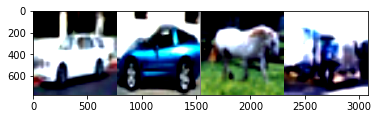

[ ' c a r '   ' c a r '   ' h o r s e '   ' t r u c k ' ]


In [21]:

from matplotlib import pyplot as plt
%matplotlib inline
images, labels = dataiter.next()#load a batch of images and labels
test_utils.imshow(tv.utils.make_grid(images))
print (' '.join('%5s' % classes[labels]))

In [4]:
#BASE layer using yolo. yolo_base only includes convolutional layers
#     base layer use tiny-yolo should have 89% accuracy in cifar using adam, which should be good
#yolo = yolo_base.load_model(img_size)
yolo = yolo_base.load_model(tile_size)
#NOW, set requires_grad = False to free all those layers (those layers don't need to learn anymore)

#assuming not freeing the yolo layers
#for param in yolo.parameters():
#    param.requires_grad = False
    
#now, create combiner network
comb_list = [Combiner() for i in range(tile_n)]
#net = t.nn.DataParallel(net)#allow using 2 GPU
for comb in comb_list:
    comb.to(device)

    
pred = Predictor()
pred.to(device)

#NOW, set requires_grad = False to free all those layers (those layers don't need to learn anymore)

#assuming not freeing the yolo layers
#for param in yolo.parameters():
#    param.requires_grad = False
    
#now, create combiner network
comb_list = [Combiner() for i in range(tile_n)]
#net = t.nn.DataParallel(net)#allow using 2 GPU
for comb in comb_list:
    comb.to(device)

    
pred = Predictor()
pred.to(device)

param_list = []
param_list += yolo.parameters()
for comb in comb_list: 
    param_list += comb.parameters()
param_list += pred.parameters()
#Now, off with the traning
learning_rate = 4e-4
optim = t.optim.Adam(param_list, lr=learning_rate, weight_decay=1e-5)



In [ ]:
import timeit

N_EPOCH = 100
N_REPORT = 2000
loss_log = []
d = t.nn.CrossEntropyLoss()

with open('loss_log.txt', 'w') as f_log:
    btime = timeit.default_timer()
    for epoch in range(N_EPOCH):
        running_loss = 0.
        for i, (img_list, label_list) in enumerate(trainloader):
            start = t.cuda.Event(enable_timing=True)
            end = t.cuda.Event(enable_timing=True)
            start.record() ###measure training time for one iteration

            label_list = label_list.to(device)
            tile_list = get_tile_list(img_list, tile_size, step)
            fx = forward(yolo, comb_list, pred, tile_list, device)
            loss = d(fx, label_list)#loss

            optim.zero_grad()
            loss.backward()#now backward, grad in graph will have something
            #clipping, I guess there is a problem with gradient exploding
            #t.nn.utils.clip_grad_norm_(net.parameters(), 1.0) #NOTE: prevent gradient exploding
            optim.step()#now, the weights is update.


            running_loss += loss.item()
            if i % N_REPORT == N_REPORT-1:    # print every 2000 mini-batches
                end.record()
                t.cuda.synchronize()

                print ('iter time: {}, exec time: {}, cur learning rate: {}'.format(start.elapsed_time(end), timeit.default_timer() - btime, test_utils.get_lr(optim)))
                btime = timeit.default_timer()
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                loss_log.append(running_loss/2000)
                running_loss = 0.0


        #periodically check model performance on testset to detect overfitting
        correct, total = eval_accuracy(yolo, comb_list, pred, testloader, device)
        print('Eval Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total))
        f_log.write('{},{}\n'.format(loss_log[-1], correct*100./total))

        #save model just incase (e.g. gradient exploding may ruin current model)
        if epoch % 5 ==0 and epoch > 1:
            t.save([yolo.state_dict(), [comb.state_dict() for comb in comb_list], pred.state_dict()], './models/yolo_tile4x4_fc_cifar{}'.format(epoch))

In [ ]:
eval_accuracy(yolo, comb_list, pred, testloader, device)

In [ ]:
fx.shape


In [ ]:
5671./10000

In [ ]:
import sys
!{sys.executable} -m pip install scikit-image

In [ ]:
# training the model for regression dataset

from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('./dataset/regressionDataset/testdata.csv')
n=1

class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.landmarks_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}
    
face_dataset = FaceLandmarksDataset(csv_file='./dataset/regressionDataset/testdata.csv',root_dir='./dataset/regressionDatset') 
transformed_dataset = FaceLandmarksDataset(csv_file='./dataset/regressionDataset/testdata.csv',root_dir='./dataset/regressionDataset',transform=transforms.Compose([ToTensor()]))
dataloader = DataLoader(transformed_dataset, batch_size=1,shuffle=True, num_workers=4)
print (dataloader)

# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,landmarks_batch[i, :, 1].numpy() + grid_border_size,s=10, marker='.', c='r')
        plt.title('Batch from dataloader')
        
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),sample_batched['landmarks'].size())
    plt.figure()
    show_landmarks_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()


In [ ]:
# train for simple CNN model 

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import imageio
import torch.nn as nn
import torch.nn.functional as F

      
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
EPOCH = 1

for epoch in range(EPOCH):
    for step, (sample_batched) in enumerate(dataloader): # for each training step
        b_x = Variable(sample_batched['image'].type(torch.FloatTensor))
        b_y = Variable(sample_batched['landmarks'])
        print (b_x)
        tile_list = get_tile_list(b_x, tile_size, step)
        fx = forward(yolo, comb_list, pred, tile_list, device)
        #prediction = net(b_x)     # input x and predict based on x
        loss = loss_func(prediction, fx)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        break

In [ ]:
img_size_h, img_size_w

In [5]:
from ptflops import get_model_complexity_info
with t.cuda.device(0):
    net = yolo
    flops, params = get_model_complexity_info(net, (3, 1472, 1472), as_strings=True, print_per_layer_stat=False)
    print('Flops:  ' + flops)
    print('Params: ' + params)

Flops:  23.68 GMac
Params: 6.3 M


In [ ]:
#yolo = yolo_base.load_model(tile_size)

#for comb in comb_list:

#pred.to(device)

<Figure size 432x288 with 0 Axes>

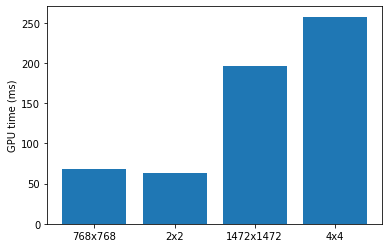

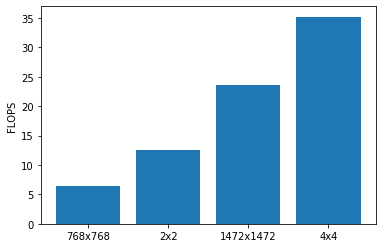

<Figure size 432x288 with 0 Axes>

In [48]:
from matplotlib import pyplot as plt
%matplotlib inline

exec_time = [67.974, 63.071, 196.66, 257.4766]
x = np.arange(len(exec_time))
x_labels = '768x768', '2x2', '1472x1472', '4x4'

exec_flop_2x2 = 1.89 * 4 + 0.03 + 4.94
exec_flop_4x4 = 1.89 * 16 + 0.03 + 4.94
exec_flop_768 = 6.45
exec_flop_1472 = 23.68

exec_flop = exec_flop_768, exec_flop_2x2,  exec_flop_1472, exec_flop_4x4

plt.bar(x, exec_time)
plt.xticks(x, x_labels)
plt.ylabel('GPU time (ms)')
plt.savefig('./figs/exec_time.jpg', dpi=300)
plt.figure()

plt.bar(x, exec_flop)
plt.xticks(x, x_labels)
plt.ylabel('FLOPS')
plt.savefig('./figs/exec_flop.jpg', dpi=300)
plt.figure()


<Figure size 432x288 with 0 Axes>

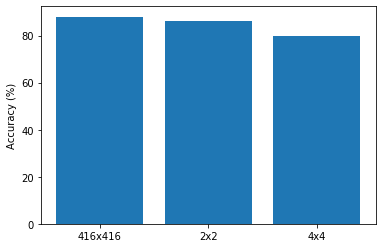

<Figure size 432x288 with 0 Axes>

In [49]:
#measure accuracy
perf_acc = [88, 86, 80]
x = np.arange(len(perf_acc))
x_labels = ['416x416', '2x2', '4x4']
plt.bar(x, perf_acc)
plt.xticks(x, x_labels)
plt.ylabel('Accuracy (%)')
plt.savefig('./figs/perm_acc.jpg', dpi=300)
plt.figure()

In [6]:
###Measuring inference time
with t.no_grad():
    result = []
    for i in range(10):
        start = t.cuda.Event(enable_timing=True)
        end = t.cuda.Event(enable_timing=True)
        start.record() ###measure training time for one iteration
        
        #for testing YOLO alone
        #img_list = t.rand(4, 3, 768, 768).to(device)
        #yolo(img_list)
        
        #for testing YOLO tile
        tile_list = t.rand(16, 4, 3, 416, 416)
        forward(yolo, comb_list, pred, tile_list, device)
        end.record()
        t.cuda.synchronize()
        exec_time=start.elapsed_time(end)
        result.append(exec_time)
        print ('exec time: {}'.format(exec_time))
    print (np.mean(result))

exec time: 283.1023254394531
exec time: 262.8515930175781
exec time: 262.5689392089844
exec time: 259.93603515625
exec time: 259.1136779785156
exec time: 260.1634216308594
exec time: 258.36541748046875
exec time: 257.9424133300781
exec time: 260.6632995605469
exec time: 257.7121276855469
262.24192504882814


<Figure size 432x288 with 0 Axes>

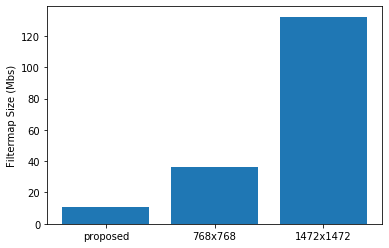

<Figure size 432x288 with 0 Axes>

In [54]:
#TEST MEM
#MEMORY CONSUMPTION of PROPOSED MODELS
from matplotlib import pyplot as plt
%matplotlib inline
def f_memsize(x):
    return x.element_size() * x.nelement()/1024/1024

x_proposed = t.rand(1024, 28, 28)
x_416 = t.rand(16, 416, 416)
x_768 = t.rand(16, 768, 768)
x_1472 = t.rand(16, 1472, 1472)
filtermap = x_416, x_768, x_1472
mem_filtermap = [f_memsize(item) for item in filtermap]

x = np.arange(len(mem_filtermap))
x_labels = 'proposed', '768x768', '1472x1472'
plt.bar(x, mem_filtermap)
plt.xticks(x, x_labels)
plt.ylabel('Filtermap Size (Mbs)')
plt.savefig('./figs/mem_filtermap2.jpg', dpi=300)
plt.figure()

In [38]:
#TEST MEM
#MEMORY CONSUMPTION
from matplotlib import pyplot as plt
%matplotlib inline
def f_memsize(x):
    return x.element_size() * x.nelement()/1024/1024
size_list = np.arange(256, 4096, 256)
for size in size_list:
    xvgg = t.rand(64, size, size)
    print (f_memsize(xvgg))

    


16.0
64.0
144.0
256.0
400.0
576.0
784.0
1024.0
1296.0
1600.0
1936.0
2304.0
2704.0
3136.0
3600.0


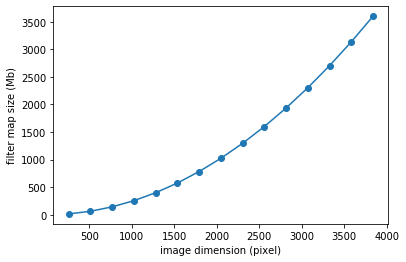

In [45]:
vgg_list = [16.0, 64.0, 144.0, 256.0, 400.0, 576.0, 784.0, 1024.0, 1296.0, 1600.0, 1936.0, 2304.0, 2704.0, 3136.0, 3600.0]
plt.scatter (size_list, vgg_list)
plt.plot(size_list, vgg_list)
plt.xlabel('image dimension (pixel)')
plt.ylabel('filter map size (Mb)')
plt.savefig('./figs/mem_filtermap.jpg', dpi=300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)


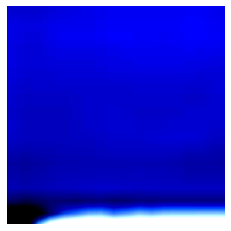

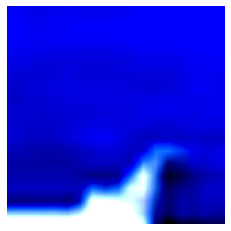

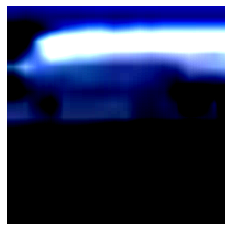

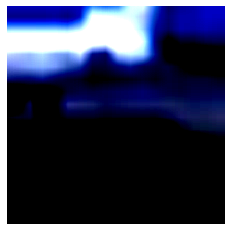

<Figure size 432x288 with 0 Axes>

In [26]:
#SHOW individual tile
for i, (img_list, label_list) in enumerate(trainloader):
    break
tile_list = get_tile_list(img_list, tile_size, step)
for tile in tile_list:
    plt.axis('off')
    tile = np.array(tile[0]).transpose(1, 2, 0)
    print (tile.shape)
    plt.imshow(tile)
    plt.figure()